In [10]:
%reset -f
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np
plt.rcParams['figure.figsize'] = [12, 8]

The functions below will only help us reconstruct the images from pystan sampling/fitting results

In [11]:
def kernel(a, b,l):
    sqd=np.subtract.outer(a,b)**2
    return np.exp(-0.5*sqd/(l*l))

def get_GP_mean(tp,P,t,l):
    K=kernel(tp,tp,l);       #NPxNP
    Ks=kernel(tp,t,l);       #NPxN
    L=np.linalg.cholesky(K)# + 1e-15*np.eye(NP)); #NPxNP
    Lk=np.linalg.solve(L,Ks);      #NPxN
    z=np.linalg.solve(L,P);        #NP
    m=np.dot(Lk.T,z)   # ((Lk)')*z;// N
    return m;

We now work on a particular system in the ztf-1a data. The system no is 37755722. Below we plot the light curve in each band (red, green and indigo).

../read_data/ztf-1a/ztf-1a_stackedflux_sysn37755722_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn37755722_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn37755722_band_ztfi


<ErrorbarContainer object of 3 artists>

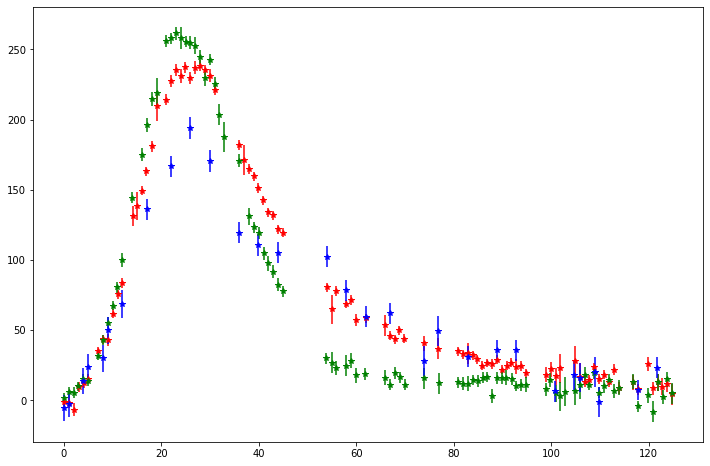

In [12]:
sysn=37755722
inp_path='../read_data/ztf-1a/'
bands=['ztfr','ztfg','ztfi']
fileN='ztf-1a_stackedflux_sysn%s_band_'%(sysn)

fileNr=inp_path+fileN+bands[0];print(fileNr)
fileNg=inp_path+fileN+bands[1];print(fileNg)
fileNi=inp_path+fileN+bands[2];print(fileNi)

tr,fr,sigfr=np.loadtxt(fileNr,usecols=[0,1,2], unpack=True)
tg,fg,sigfg=np.loadtxt(fileNg,usecols=[0,1,2], unpack=True)
ti,fi,sigfi=np.loadtxt(fileNi,usecols=[0,1,2], unpack=True)

t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti)])
t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti)])
t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs)+1e-5;

# we substract a fixed time, it should not have any effect on the pystan results
tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; 

t_max=t_max-t_min; t_min=0.0;

c=['r','g','b']
plt.rcParams['figure.figsize'] = [12, 8]
plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]))
plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]))
plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]))


In [ ]:
print("printing the flux in r-band",fr)

Why first few data points on r-band have negative flux??

Details of images of the system: sysno==37755722

In [14]:
import pandas as pd
datapath="/home/users/satadru/lensed_supernovae/data"
fin=datapath+'/ztf-1a.h5'
dfI=pd.read_hdf(fin, 'image')
print(dfI[dfI['sysno']==sysn])

INFO:numexpr.utils:Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


         td         x         y        mu     sysno  imno
0  0.000000 -1.085469 -0.351792  1.625969  37755722     0
1  6.036739  0.226822 -0.012941 -0.903586  37755722     1


We see that we have 2 images with a time delay of 6.036739 days. I am not sure what negative aplification means here (in the catalogue they said negative amplification means opposite "parity"!). Anyway, disregarding this negative sign we expect $\mu=1.625969/0.903586 \sim 1.8$ and $dt \sim 6.04$ from the following code.

First we try with $N_P=10$ for all the bands. The code below is not written nicely for now, rather it is written explicitly to avoid any mistake.

In [15]:

model = """
functions{
    matrix kernel1(vector x0, vector x1, real l, int d){
        matrix [d,d] a;
        for (i in 1:d)
        {
            for (j in 1:i)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    
    matrix kernel2(vector x0, vector x1, real l, int d1, int d2){
        matrix [d1,d2] a;
        for (i in 1:d1)
        {
            for (j in 1:d2)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
            }
            
        }
        return a;
    }
    //================== calculating GP mean function =============================
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel1(tp,tp,l, NP);       //NPxNP
        Ks=kernel2(tp,t,l, NP,N);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
    //==============================================================================
}

data{

    int<lower=0> ni;
    int<lower=5> NP;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;


    vector[NP] tp;
    real td;
    real dt_max;
}
parameters {
    vector <lower=0.0, upper=300> [NP] Pr;
    vector <lower=0.0, upper=300> [NP] Pg;
    vector <lower=0.0, upper=300> [NP] Pi;
    
    
    real<lower=5.0, upper=25.0> lr;
    real<lower=5.0, upper=25.0> lg;
    real<lower=5.0, upper=25.0> li;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;

    //dum needs GP
    dumr=GP_mean(tp, tr, Pr, lr, NP, Nr); //first image
    dumr=dumr+mu*GP_mean(tp, tr+dt, Pr, lr, NP, Nr); //adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=GP_mean(tp, tg, Pg, lg, NP, Ng); //first image
    dumg=dumg+mu*GP_mean(tp, tg+dt, Pg, lg, NP, Ng); //adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=GP_mean(tp, ti, Pi, li, NP, Ni); //first image
    dumi=dumi+mu*GP_mean(tp, ti+dt, Pi, li, NP, Ni); //adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);

}
"""
NI=2
NP=10;
dt_min=0.0; dt_max=15.0
#t_range=np.amax(t)-np.amin(t)
tp=np.linspace(t_min, t_max+dt_max, NP)
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit2 = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit2)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a7415e66126a87581311b13dcd86cc2a NOW.


tp= [  0.          15.54345814  31.08691628  46.63037442  62.17383256
  77.7172907   93.26074885 108.80420699 124.34766513 139.89112327]
td= 15.543458140873959
Inference for Stan model: anon_model_a7415e66126a87581311b13dcd86cc2a.
4 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=2136.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Pr[1]    3.61    0.06    2.2   0.23   1.89   3.42   5.05   8.41   1264    1.0
Pr[2]    7.75    0.04   1.27   4.93   6.96   7.84   8.66   9.98   1289    1.0
Pr[3]  101.87    0.18   5.48   90.3   98.6 102.23 105.55 111.99    962    1.0
Pr[4]   52.54    0.05   1.62  49.16  51.55  52.66  53.61  55.54   1055    1.0
Pr[5]   28.51    0.04   1.42  25.43  27.63  28.53  29.47  31.22   1108    1.0
Pr[6]   14.82    0.02   0.93  13.02   14.2  14.83  15.42  16.67   1520    1.0
Pr[7]   10.74    0.02   0.74   9.26  10.24  10.73  11.24   12.2   1306    1.0
Pr[8]    6.43    0.02   0.93 

36 10 10 10
1.697037150339127 10.79125791530441
P's are calculated at t=  [  0.          15.54345814  31.08691628  46.63037442  62.17383256
  77.7172907   93.26074885 108.80420699 124.34766513 139.89112327]

 
 chi^2--> r-band= 79.7693093062419 , g-band= 84.08296372934733 , i-band= 26.492403913746156
data points in r-band= 90 , g-band= 91 , i-band= 30


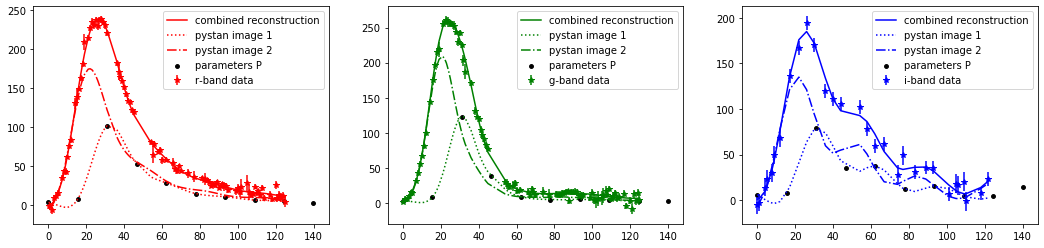

In [16]:
plt.rcParams['figure.figsize'] = [18,4 ]

def rec(fit,pnr,png,pni):
    tpr=np.linspace(t_min, t_max+dt_max, pnr);
    tpg=np.linspace(t_min, t_max+dt_max, png);
    tpi=np.linspace(t_min, t_max+dt_max, pni);
    
    pp1=fit.get_posterior_mean()
    pos_mean=np.mean(pp1,axis=1)


    Pr_mean=pos_mean[np.arange(0,pnr)]; Pg_mean=pos_mean[np.arange(pnr,pnr+png)];
    Pi_mean=pos_mean[np.arange(pnr+png,pnr+png+pni)];
    print(len(pos_mean),len(Pr_mean),len(Pg_mean),len(Pi_mean))

    lrm=pos_mean[-6]; lgm=pos_mean[-5];lim=pos_mean[-4];

    mum=pos_mean[-3]; dtm=pos_mean[-2]; print(mum,dtm)
    
    if(pnr==pni):
        print("P's are calculated at t= ",tpr)


    Ps1r=get_GP_mean(tpr,Pr_mean,tr,lrm)
    Ps2r=mum*get_GP_mean(tpr,Pr_mean,tr+dtm,lrm)
    rconst_signal_r=Ps1r+Ps2r#+Ps3+Ps4;
    Psr=Ps1r+Ps2r


    Ps1g=get_GP_mean(tpg,Pg_mean,tg,lgm)
    Ps2g=mum*get_GP_mean(tpg,Pg_mean,tg+dtm,lgm)
    rconst_signal_g=Ps1g+Ps2g#+Ps3+Ps4;
    Psg=Ps1g+Ps2g

    Ps1i=get_GP_mean(tpi,Pi_mean,ti,lim)
    Ps2i=mum*get_GP_mean(tpi,Pi_mean,ti+dtm,lim)
    rconst_signal_i=Ps1i+Ps2i#+Ps3+Ps4;
    Psi=Ps1i+Ps2i

    chisq_r=np.sum((Psr-fr)**2/sigfr**2); chisq_g=np.sum((Psg-fg)**2/sigfg**2); chisq_i=np.sum((Psi-fi)**2/sigfi**2)
    print("\n \n chi^2--> r-band=",chisq_r, ", g-band=",chisq_g, ", i-band=", chisq_i)
    print("data points in r-band=",len(tr), ", g-band=",len(tg), ", i-band=",len(ti))
    plt.subplot(1, 3, 1)
    plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]), label=r"r-band data")
    plt.plot(tr,Psr, c=c[0], label=r"combined reconstruction" )
    plt.plot(tr,Ps1r, ls="dotted", c=c[0], label=r"pystan image 1")
    plt.plot(tr,Ps2r, ls="dashdot", c=c[0], label=r"pystan image 2")
    plt.scatter(tpr, Pr_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    

    plt.subplot(1, 3, 2)
    plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]), label=r"g-band data")
    plt.plot(tg,Psg, c=c[1], label=r"combined reconstruction")
    plt.plot(tg,Ps1g, ls="dotted", c=c[1], label=r"pystan image 1")
    plt.plot(tg,Ps2g, ls="dashdot", c=c[1], label=r"pystan image 2")
    plt.scatter(tpg, Pg_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]), label=r"i-band data")
    plt.plot(ti,Psi, c=c[2], label=r"combined reconstruction")
    plt.plot(ti,Ps1i, ls="dotted", c=c[2], label=r"pystan image 1")
    plt.plot(ti,Ps2i, ls="dashdot", c=c[2], label=r"pystan image 2")
    plt.scatter(tpi, Pi_mean, c="k", s=15, label=r"parameters P")
    plt.legend()
    plt.show()

rec(fit2, 10,10,10)

The overall $\chi^2$ is good. The constrained $\mu \approx 1.7 \pm 0.11$ is also nice. But the time delay ($dt \approx 10.8 \pm 0.2$) is much higher than expected. This is possibly because my parameters P are very much spread in time. Possibly we need higher NP. Look at the i-band. The reconstructed signal looks bad. Possibly we need fewer parameters for i-band.

Below we try with NP=15, same for all the bands.

In [17]:

model = """
functions{
    matrix kernel1(vector x0, vector x1, real l, int d){
        matrix [d,d] a;
        for (i in 1:d)
        {
            for (j in 1:i)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    
    matrix kernel2(vector x0, vector x1, real l, int d1, int d2){
        matrix [d1,d2] a;
        for (i in 1:d1)
        {
            for (j in 1:d2)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
            }
            
        }
        return a;
    }
    //================== calculating GP mean function =============================
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel1(tp,tp,l, NP);       //NPxNP
        Ks=kernel2(tp,t,l, NP,N);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
    //==============================================================================
}

data{

    int<lower=0> ni;
    int<lower=5> NP;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;


    vector[NP] tp;
    real td;
    real dt_max;
}
parameters {
    vector <lower=0.0, upper=300> [NP] Pr;
    vector <lower=0.0, upper=300> [NP] Pg;
    vector <lower=0.0, upper=300> [NP] Pi;
    
    
    real<lower=5.0, upper=40.0> lr;
    real<lower=5.0, upper=40.0> lg;
    real<lower=5.0, upper=40.0> li;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;

    //dum needs GP
    dumr=GP_mean(tp, tr, Pr, lr, NP, Nr); //first image
    dumr=dumr+mu*GP_mean(tp, tr+dt, Pr, lr, NP, Nr); //adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=GP_mean(tp, tg, Pg, lg, NP, Ng); //first image
    dumg=dumg+mu*GP_mean(tp, tg+dt, Pg, lg, NP, Ng); //adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=GP_mean(tp, ti, Pi, li, NP, Ni); //first image
    dumi=dumi+mu*GP_mean(tp, ti+dt, Pi, li, NP, Ni); //adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);

}
"""
NI=2
NP=15;
dt_min=0.0; dt_max=15.0
#t_range=np.amax(t)-np.amin(t)
tp=np.linspace(t_min, t_max+dt_max, NP)
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit3 = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit3)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d579889c2bfd51cc8919d02383ae8133 NOW.


tp= [  0.           9.99222309  19.98444618  29.97666927  39.96889236
  49.96111545  59.95333854  69.94556163  79.93778472  89.93000782
  99.92223091 109.914454   119.90667709 129.89890018 139.89112327]
td= 9.992223090561831


Inference for Stan model: anon_model_d579889c2bfd51cc8919d02383ae8133.
4 chains, each with iter=2000; warmup=400; thin=3; 
post-warmup draws per chain=534, total post-warmup draws=2136.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Pr[1]    0.89    0.02   0.83   0.03   0.29   0.63   1.24   3.06   2192    1.0
Pr[2]   18.81    0.56   9.25   5.27  11.77  17.19  24.83  42.72    271    1.0
Pr[3]  138.62    0.55  10.66 118.91  130.5 138.44 147.47 156.48    377    1.0
Pr[4]  181.23     0.3   6.88 167.22 176.44 181.46 186.69 192.76    516   1.01
Pr[5]  120.57     0.2    4.6 110.99 117.42 120.67 124.13 128.25    516    1.0
Pr[6]    76.5    0.14   3.75  68.71  74.07  76.64  79.18  83.38    700    1.0
Pr[7]   50.73     0.1   2.36   46.0  49.11   50.8  52.37  55.13    566    1.0
Pr[8]   33.72    0.08   2.21  29.37  32.17   33.8   35.4  37.69    732    1.0
Pr[9]   27.78    0.06   2.25  23.27  26.23  27.88  29.29  32.09   1234    1.0
Pr[10]  19.06    0.05   1.64   15

51 15 15 15
0.36207664759006764 8.139195143961459
P's are calculated at t=  [  0.           9.99222309  19.98444618  29.97666927  39.96889236
  49.96111545  59.95333854  69.94556163  79.93778472  89.93000782
  99.92223091 109.914454   119.90667709 129.89890018 139.89112327]

 
 chi^2--> r-band= 83.26617164922385 , g-band= 97.83698801266985 , i-band= 18.153281522295494
data points in r-band= 90 , g-band= 91 , i-band= 30


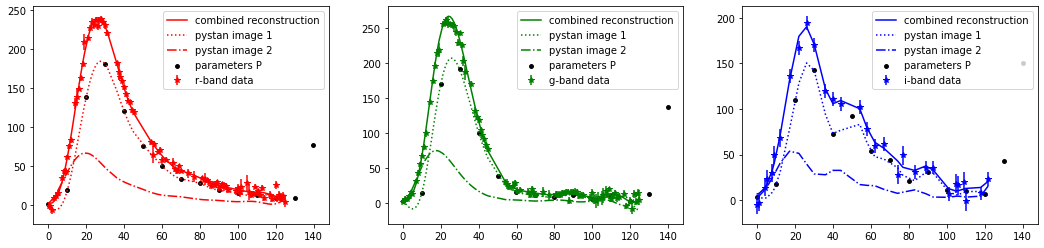

In [18]:
npn=15
rec(fit3, npn,npn,npn)

Again the overall fit is quite good. The time delay, $dt = 8.14 \pm 1.56$ is better now. But now the amplification is too small. This is possibly because of more freedom to the first image. The i-band images are bad. 

Below we try with NP=8, same for all the bands.

In [19]:

model = """
functions{
    matrix kernel1(vector x0, vector x1, real l, int d){
        matrix [d,d] a;
        for (i in 1:d)
        {
            for (j in 1:i)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    
    matrix kernel2(vector x0, vector x1, real l, int d1, int d2){
        matrix [d1,d2] a;
        for (i in 1:d1)
        {
            for (j in 1:d2)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
            }
            
        }
        return a;
    }
    //================== calculating GP mean function =============================
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel1(tp,tp,l, NP);       //NPxNP
        Ks=kernel2(tp,t,l, NP,N);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
    //==============================================================================
}

data{

    int<lower=0> ni;
    int<lower=5> NP;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;


    vector[NP] tp;
    real td;
    real dt_max;
}
parameters {
    vector <lower=0.0, upper=300> [NP] Pr;
    vector <lower=0.0, upper=300> [NP] Pg;
    vector <lower=0.0, upper=300> [NP] Pi;
    
    
    real<lower=5.0, upper=25.0> lr;
    real<lower=5.0, upper=25.0> lg;
    real<lower=5.0, upper=25.0> li;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;

    //dum needs GP
    dumr=GP_mean(tp, tr, Pr, lr, NP, Nr); //first image
    dumr=dumr+mu*GP_mean(tp, tr+dt, Pr, lr, NP, Nr); //adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=GP_mean(tp, tg, Pg, lg, NP, Ng); //first image
    dumg=dumg+mu*GP_mean(tp, tg+dt, Pg, lg, NP, Ng); //adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=GP_mean(tp, ti, Pi, li, NP, Ni); //first image
    dumi=dumi+mu*GP_mean(tp, ti+dt, Pi, li, NP, Ni); //adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);

}
"""
NI=2
NP=8;
dt_min=0.0; dt_max=15.0
#t_range=np.amax(t)-np.amin(t)
tp=np.linspace(t_min, t_max+dt_max, NP)
print("tp=",tp)
td=(t_max-t_min+dt_max-dt_min)/(NP-1); print("td=",td);
data = {'ni':NI,'NP':NP,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tp':tp,'td':td, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit0 = sm.sampling(data=data, iter=2500, chains=4, warmup=400, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit0)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a7415e66126a87581311b13dcd86cc2a NOW.


tp= [  0.          19.98444618  39.96889236  59.95333854  79.93778472
  99.92223091 119.90667709 139.89112327]
td= 19.984446181123662


Inference for Stan model: anon_model_a7415e66126a87581311b13dcd86cc2a.
4 chains, each with iter=2500; warmup=400; thin=3; 
post-warmup draws per chain=700, total post-warmup draws=2800.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Pr[1]   0.04  7.6e-4   0.04 1.2e-3   0.01   0.03   0.05   0.15   2745    1.0
Pr[2] 145.53    0.28   4.66 133.65 143.15 146.81 148.97 151.21    269   1.03
Pr[3] 125.33    0.25   4.02  114.9  123.3 126.39 128.33 130.31    261   1.03
Pr[4]  44.75    0.09   1.69  40.78  43.79   45.0  45.94  47.45    339   1.03
Pr[5]  28.12    0.06   1.28  25.27  27.32  28.22   29.0   30.4    423   1.02
Pr[6]  12.59    0.03   1.09  10.43  11.85  12.58  13.33  14.68   1405   1.01
Pr[7]  11.86    0.03   1.22   9.52  11.01  11.85  12.66  14.24   1700    1.0
Pr[8]   2.27    0.04   2.15   0.08   0.68   1.62   3.25   7.88   2794    1.0
Pg[1]   0.04  7.6e-4   0.04 1.1e-3   0.01   0.03   0.05   0.14   2691    1.0
Pg[2] 166.03    0.33   5.33 152.13  163.4 1

30 8 8 8
0.2956200976789238 0.008428038950967156
P's are calculated at t=  [  0.          19.98444618  39.96889236  59.95333854  79.93778472
  99.92223091 119.90667709 139.89112327]

 
 chi^2--> r-band= 1450.868070105662 , g-band= 1792.2996718990908 , i-band= 75.80974750345563
data points in r-band= 90 , g-band= 91 , i-band= 30


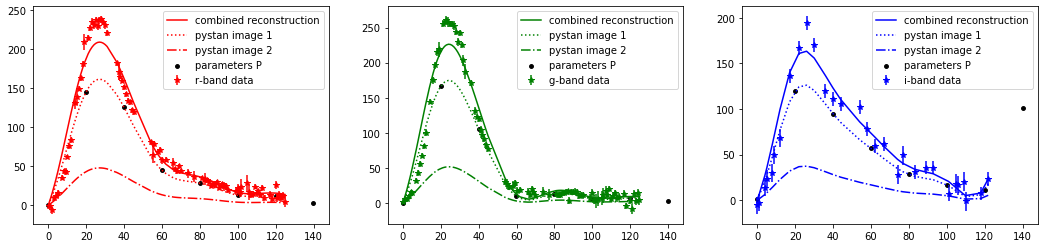

In [20]:
rec(fit0, 8,8,8)

The above fit is very bad, but at least the i-band images look a bit nicer!

Let us try with different number of parameters for different bands. NP=15 for red and green bands, while NP=8 for i-band.

In [ ]:

model = """
functions{
    matrix kernel1(vector x0, vector x1, real l, int d){
        matrix [d,d] a;
        for (i in 1:d)
        {
            for (j in 1:i)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
                a[j][i]=a[i][j];
            }
            
        }
        return a;
    }
    
    matrix kernel2(vector x0, vector x1, real l, int d1, int d2){
        matrix [d1,d2] a;
        for (i in 1:d1)
        {
            for (j in 1:d2)
            {
                a[i][j]=exp(-0.5*(x0[i]-x1[j])*(x0[i]-x1[j])/(l*l));
            }
            
        }
        return a;
    }
    //================== calculating GP mean function =============================
    vector GP_mean(vector tp, vector t, vector P, real l, int NP, int N)
    {
        matrix[NP,NP] K;
        matrix[NP,NP] L;
        matrix[NP,N] Ks;
        matrix[NP,N] Lk;
        vector[NP] z;
        vector[N] m;
    
        K=kernel1(tp,tp,l, NP);       //NPxNP
        Ks=kernel2(tp,t,l, NP,N);       //NPxN
        L=cholesky_decompose(K); //NPxNP
        Lk=L\Ks;      //NPxN
        z=L\P;        //NP
        m=((Lk)')*z;// N
        return m;
    }
    //==============================================================================
}

data{

    int<lower=0> ni;
    
    int<lower=5> NPr;
    int<lower=5> NPg;
    int<lower=5> NPi;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;


    vector[NPr] tpr;
    vector[NPg] tpg;
    vector[NPi] tpi;
    
    real dt_max;
}
parameters {
    vector <lower=0.0, upper=300.0> [NPr] Pr;
    vector <lower=0.0, upper=300.0> [NPg] Pg;
    vector <lower=0.0, upper=300.0> [NPi] Pi;
    
    
    real<lower=5.0, upper=40.0> lr;
    real<lower=5.0, upper=40.0> lg;
    real<lower=5.0, upper=40.0> li;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;

    //dum needs GP
    dumr=GP_mean(tpr, tr, Pr, lr, NPr, Nr); //first image
    dumr=dumr+mu*GP_mean(tpr, tr+dt, Pr, lr, NPr, Nr); //adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=GP_mean(tpg, tg, Pg, lg, NPg, Ng); //first image
    dumg=dumg+mu*GP_mean(tpg, tg+dt, Pg, lg, NPg, Ng); //adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=GP_mean(tpi, ti, Pi, li, NPi, Ni); //first image
    dumi=dumi+mu*GP_mean(tpi, ti+dt, Pi, li, NPi, Ni); //adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);

}
"""
NI=2
NPr=15; NPg=15; NPi=8;# number of parameters is different for different bands
dt_min=0.0; dt_max=15.0
#now we calculate the time array for each band since the number of parameters can be different
tpr=np.linspace(t_min, t_max+dt_max, NPr); tpg=np.linspace(t_min, t_max+dt_max, NPg); 
tpi=np.linspace(t_min, t_max+dt_max, NPi); 
data = {'ni':NI,'NPr':NPr,'NPg':NPg,'NPi':NPi,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti),'tr': tr, 'tg': tg, 'ti': ti,
        'yr': fr, 'yg': fg, 'yi': fi, 'yr_error':sigfr, 'yg_error':sigfg, 'yi_error':sigfi,
        'tpr':tpr,'tpg':tpg,'tpi':tpi, 'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit4 = sm.sampling(data=data, iter=2000, chains=4, warmup=400, thin=3, seed=301)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_29425fc8f12b2de0b6ff0c8e0ce88930 NOW.


In [ ]:
rec(fit4, NPr,NPg,NPi)

Results are bad. I am working on it